<h1>Classifying European Money Denominations<h1>

The dataset being used is an IMB Cloud Data set and contains a variety of images of Euro bills.


Prior to starting I need to extract the data from the tar files which contian the images

In [ ]:
import tarfile

#extracting training data
file1 = tarfile.open('data/training_data_pytorch.tar')
file1.extractall('data')

#extracting validation data
file2 = tarfile.open('data/validation_data_pytorch.tar')
file2.extractall('data')

#extracting test data
file3 = tarfile.open('data/test_data_pytorch.tar')
file3.extractall('data')

Verifying data was loaded in

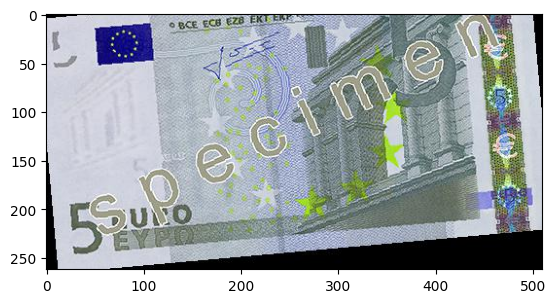

In [1]:
import matplotlib as plt
import matplotlib.pyplot
from PIL import Image

img = Image.open('data/training_data_pytorch/0.jpeg')
plt.pyplot.imshow(img)

In [2]:
#importing necessary libraries
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
##Creating dataset class
class Dataset():

    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        
        # Image directory
        self.data_dir=data_dir
        
        # The transform is goint to be used on image
        self.transform = transform
        
        # Load the CSV file contians image info
        self.data_name= pd.read_csv(csv_file)
        
        # Number of images in dataset
        self.len=self.data_name.shape[0] 
    
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        # Image file path
        img_name=self.data_dir + self.data_name.iloc[idx, 2]
        
        # Open image file
        image = Image.open(img_name)
        
        # The class label for the image
        y = self.data_name.iloc[idx, 3]
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [4]:
##creating data transform
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(), transforms.Normalize(mean, std)])

In [5]:
#Creating the train and validation datasets
train_dataset = Dataset(transform=composed, csv_file='data/training_labels.csv', data_dir='data/training_data_pytorch/')
validation_dataset = Dataset(transform=composed, csv_file='data/validation_labels.csv', data_dir='data/validation_data_pytorch/')


In [6]:
#loading pretrained resnet18 model
model = models.resnet18(pretrained=True)

#making sure model parameters are not affected by training
for param in model.parameters():
    param.requires_grad=False

#redefinining the last layers to classify 7 different bills
model.fc = nn.Linear(512, 7)

print(model)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
#loss function
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr=0.003)

In [8]:
#training loader with batch size 15
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
#validation loader with batch size 10
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=10)

In [9]:
#training the model
N_EPOCHS = 20
loss_list = []
accuracy_list = []
correct = 0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    loss_sublist = []
    for x,y in train_loader:
        model.train()
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))

    for x_test, y_test in validation_loader:
        model.eval()
        z = model(x_test)
        _,yhat = torch.max(z.data, 1)

        correct += (yhat == y_test).sum().item()

    accuracy = correct / n_test
    accuracy_list.append(accuracy)



[4.141960859298706, 1.876476812362671, 1.8693339228630066, 1.9902428150177003, 1.654126811027527, 1.3869779706001282, 1.178055191040039, 1.1778183221817016, 1.1725499391555787, 1.0857449650764466, 0.9880804061889649, 0.9254357814788818, 0.9061985492706299, 0.8791752338409424, 0.8333613395690918, 0.7874194622039795, 0.7553169250488281, 0.7316631555557251, 0.7049598574638367, 0.6751049399375916]


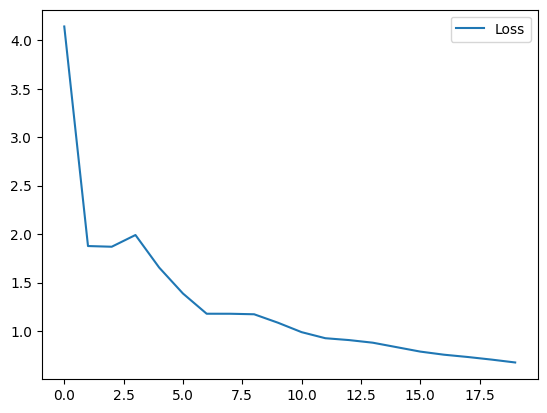

In [10]:
print(loss_list)
#plotting loss
plt.plot(loss_list, label="Loss")
plt.legend()
plt.show()

[0.32857142857142857, 0.5142857142857142, 0.6857142857142857, 1.1714285714285715, 1.8428571428571427, 2.557142857142857, 3.242857142857143, 3.914285714285714, 4.728571428571429, 5.6, 6.5, 7.414285714285715, 8.32857142857143, 9.271428571428572, 10.214285714285714, 11.157142857142857, 12.128571428571428, 13.114285714285714, 14.1, 15.085714285714285]


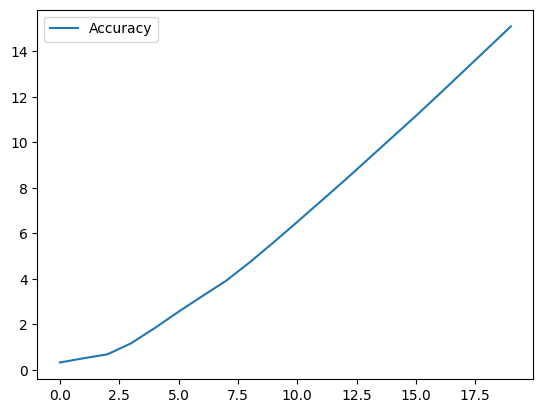

In [11]:
print(accuracy_list)
#plotting accuracy per epoch
plt.plot(accuracy_list, label="Accuracy")
plt.legend()
plt.show()

In [12]:
#loading and training a densenet model
model_des = models.densenet121(pretrained=True)
for param in model_des.parameters():
    param.requires_grad=False
model_des.classifier = nn.Linear(1024, 7)

#loss function
des_loss = nn.CrossEntropyLoss
#optimizer
optimizer = torch.optim.Adam([parameters for parameters in model_des.parameters() if parameters.requires_grad],lr=0.003)

N_EPOCHS = 10
des_loss_list = []
des_accuracy_list = []
des_correct = 0
n_test = len(validation_dataset)

for epoch in range(N_EPOCHS):
    loss_sublist = []
    for x,y in train_loader:
        model_des.train()
        optimizer.zero_grad()
        z = model_des(x)
        loss = criterion(z,y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    des_loss_list.append(np.mean(loss_sublist))

    for x_test, y_test in validation_loader:
        model_des.eval()
        z = model_des(x_test)
        _,yhat = torch.max(z.data, 1)

        des_correct += (yhat == y_test).sum().item()

    accuracy = des_correct / n_test
    des_accuracy_list.append(accuracy)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


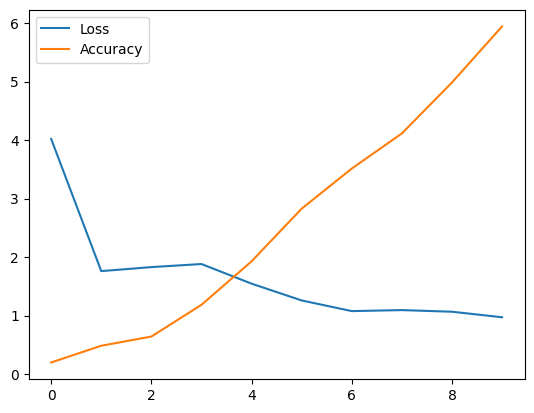

In [13]:
#plotting densenet121 loss and accuracy
plt.plot(des_loss_list, label="Loss")
plt.plot(des_accuracy_list, label="Accuracy")
plt.legend()
plt.show()

In [14]:
#saving model
torch.save(model, "resnet18_pytorch.pt")
torch.save(model_des, "densenet121_pytorch.pt")

In [15]:
#loading previously trained models
model = torch.load("models/resnet18_pytorch.pt")
model_des = torch.load("models/densenet121_pytorch.pt")

#Printing model structure
print("ResNet18:\n", model)
print("Densenet121:\n", model_des)

ResNet18:
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [16]:
#creating a test dataset and test loader
test_dataset = Dataset(transform=composed, csv_file='data/test_labels.csv',data_dir='data/test_data_pytorch/')
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10)

In [17]:
#testing resnet18 model
correct = 0
accuracy = 0
N = len(test_dataset)
for x_test, y_test in test_loader:
    model.eval()
    z = model(x_test)
    _, yhat = torch.max(z.data, 1)
    correct += (yhat == y_test).sum().item()
accuracy = correct / N
print("Accuracy using ResNet18: ", accuracy) 

Accuracy using ResNet18:  0.9714285714285714


In [18]:
#testing densenet121 model
correct = 0
accuracy = 0
N = len(test_dataset)
for x_test, y_test in test_loader:
    model_des.eval()
    z = model_des(x_test)
    _, yhat = torch.max(z.data, 1)
    correct += (yhat == y_test).sum().item()
accuracy = correct / N
print("Accuracy using Densenet121: ", accuracy) 

Accuracy using Densenet121:  0.9571428571428572
